In [18]:
import galsim

%matplotlib inline # enable ploting in notebook
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits # read and write fits file

In [8]:
gal_flux = 1.e5    # counts
gal_r0 = 2.7       # arcsec
g1 = 0.1           #
g2 = 0.2           #
psf_beta = 5       #
psf_re = 1.0       # arcsec
pixel_scale = 0.2  # arcsec / pixel
sky_level = 2.5e3  # counts / arcsec^2

# This time use a particular seed, so the image is deterministic.
# This is the same seed that is used in demo2.yaml, which means the images produced
# by the two methods will be precisely identical.
random_seed = 1534225

# Initialize the (pseudo-)random number generator that we will be using below.
# For a technical reason that will be explained later (demo9.py), we add 1 to the
# given random seed here.
rng = galsim.BaseDeviate(random_seed+1)

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)

In [12]:
# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
gal = gal.shear(g1=g1, g2=g2)

# Define the PSF profile.
psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_re)

# Final profile is the convolution of these.
final = galsim.Convolve([gal, psf])

# Draw the image with a particular pixel scale.
image = final.drawImage(scale=pixel_scale)

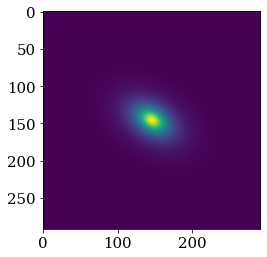

In [16]:
plt.imshow(image.array)

In [21]:
pyfits.writeto('a.fits',image.array,overwrite=True)
a=pyfits.getdata('a.fits')

In [22]:
# The "effective PSF" is the PSF as drawn on an image, which includes the convolution
# by the pixel response.  We label it epsf here.
image_epsf = psf.drawImage(scale=pixel_scale)

# To get Poisson noise on the image, we will use a class called PoissonNoise.
# However, we want the noise to correspond to what you would get with a significant
# flux from tke sky.  This is done by telling PoissonNoise to add noise from a
# sky level in addition to the counts currently in the image.
#
# One wrinkle here is that the PoissonNoise class needs the sky level in each pixel,
# while we have a sky_level in counts per arcsec^2.  So we need to convert:
sky_level_pixel = sky_level * pixel_scale**2
noise = galsim.PoissonNoise(rng, sky_level=sky_level_pixel)
image.addNoise(noise)

# Write the image to a file.
#file_name = os.path.join('output', 'demo2.fits')
#file_name_epsf = os.path.join('output','demo2_epsf.fits')
#image.write(file_name)
#image_epsf.write(file_name_epsf)

results = galsim.hsm.EstimateShear(image, image_epsf)

exp_shear = galsim.Shear(g1=g1, g2=g2)

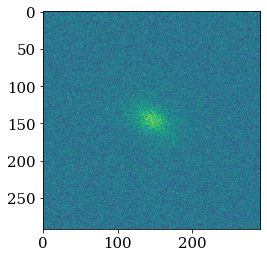

In [23]:
plt.imshow(image.array)